# Forecasting the 2020 US election

Given the structure of the US electorate, they use a two-stage modelling approach. we model how likely a respondent is to vote for Trump, given various information such as state, education, age, gender, race etc.

In [89]:
pd.set_option('display.max_columns', 300)

import pymc3 as pm
import scipy as sp

from theano import shared
import arviz as az
import plotly.graph_objects as go
import plotly.express as px

## Survey data

In [90]:
df = pd.read_stata('data/ns20200625.dta', 
                    columns=['vote_2020', 'race_ethnicity', 'education', 'state', 'gender', 'age', 'census_region'])

In [91]:
df.isnull().sum()

vote_2020         4
race_ethnicity    0
education         0
state             0
gender            0
age               0
census_region     0
dtype: int64

In [92]:
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

In [93]:
df.shape

(6475, 7)

In [94]:
df.head()

,vote_2020,race_ethnicity,education,state,gender,age,census_region
0,Donald Trump,White,Associate Degree,WI,Female,49.0,Midwest
1,I am not sure/don't know,White,"College Degree (such as B.A., B.S.)",VA,Female,39.0,South
2,Donald Trump,White,"College Degree (such as B.A., B.S.)",VA,Female,46.0,South
3,Donald Trump,White,High school graduate,TX,Female,75.0,South
4,Donald Trump,White,High school graduate,WA,Female,52.0,West


In [95]:
df.vote_2020.value_counts(normalize=True)

Joe Biden                   0.419923
Donald Trump                0.383166
I am not sure/don't know    0.100541
I would not vote            0.057761
Someone else                0.038610
Name: vote_2020, dtype: float64

In [96]:
df.state.value_counts()[:10]

CA    717
NY    519
FL    507
TX    480
OH    293
IL    291
PA    274
NC    214
NJ    206
VA    205
Name: state, dtype: int64

In [97]:
df.race_ethnicity.value_counts()

White                                 4815
Black, or African American             772
Some other race                        460
Asian (Asian Indian)                   102
American Indian or Alaska Native        89
Asian (Chinese)                         84
Asian (Filipino)                        46
Asian (Other)                           37
Asian (Japanese)                        21
Asian (Korean)                          14
Asian (Vietnamese)                      13
Pacific Islander (Native Hawaiian)      10
Pacific Islander (Other)                 8
Pacific Islander (Samoan)                3
Pacific Islander (Guamanian)             1
Name: race_ethnicity, dtype: int64

In [98]:
df.education.value_counts()

College Degree (such as B.A., B.S.)           1477
Completed some college, but no degree         1326
High school graduate                          1078
Masters degree                                 643
Completed some high school                     638
Associate Degree                               569
Other post high school vocational training     324
Completed some graduate, but no degree         237
Doctorate degree                               146
Middle School - Grades 4 - 8                    26
3rd Grade or less                               11
Name: education, dtype: int64

In [99]:
df.gender.value_counts()

Female    3305
Male      3170
Name: gender, dtype: int64

In [100]:
df.census_region.value_counts()

South        2432
West         1443
Midwest      1349
Northeast    1251
Name: census_region, dtype: int64

## Number of poll respondents by states

In [101]:
state_counts = df.groupby('state').size().reset_index().rename(columns={0: 'number of respondents'})

fig = go.Figure(data=go.Choropleth(
    locations=state_counts['state'],
    z=state_counts['number of respondents'].astype(float),
    locationmode='USA-states',
    colorscale='Reds',
    autocolorscale=False,
    marker_line_color='white', # line markers between states
    colorbar_title="Number of respondents"
))

fig.update_layout(
    title_text='Number of poll respondents by state<br>(Hover for breakdown)',
    geo = dict(
        scope='usa',
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(255, 255, 255)'),
)

fig.show()

Notably, every state had respondents.

In [102]:
df.vote_2020.value_counts()

Joe Biden                   2719
Donald Trump                2481
I am not sure/don't know     651
I would not vote             374
Someone else                 250
Name: vote_2020, dtype: int64

In [103]:
dt_df = df.copy()
vote_map_dict = {'Donald Trump': 1, 'Joe Biden': 0, "I am not sure/don't know": 0, 'I would not vote': 0, 'Someone else': 0}
dt_df['vote_2020'] = dt_df['vote_2020'].map(vote_map_dict)

## Respondents by state and race

In [104]:
race_map_dict = {'White': 'White', 'Black, or African American': 'Black', 'Some other race': 'Others', 
            'Asian (Asian Indian)': 'Asian', 'Asian (Chinese)': 'Asian', 'Asian (Filipino)': 'Asian', 'Asian (Other)': 'Asian', 
            'Asian (Japanese)': 'Asian', 'Asian (Korean)': 'Asian', 'Asian (Vietnamese)': 'Asian', 'American Indian or Alaska Native': 'Others', 
            'Pacific Islander (Native Hawaiian)': 'Others', 'Pacific Islander (Other)': 'Others', 
            'Pacific Islander (Samoan)': 'Others', 'Pacific Islander (Guamanian)': 'Others'}

dt_df['race'] = dt_df['race_ethnicity'].map(race_map_dict)

In [105]:
dt_race_df = dt_df.groupby(['state', 'race']).size().reset_index().rename(columns={0: 'Number of respondents'})

fig = px.bar(dt_race_df, x="state", y="Number of respondents",
             color='race', barmode='group',
             height=400)
fig.update_layout(title_text='Number of poll respondents by state and race')
fig.show()

All the states had white respondents, several states had only white respondents, a number of states had no black or Asian respondents, or both, even more states had very few black and Asian respondents.

In [106]:
dt_race_df.loc[dt_race_df['state'] == 'ME']

,state,race,Number of respondents
77,ME,White,20


## Respondents by state and gender

In [107]:
dt_gender_df = dt_df.groupby(['state', 'gender']).size().reset_index().rename(columns=({0: 'Number of respondents'}))

fig = px.bar(dt_gender_df, x="state", y="Number of respondents",
             color='gender', barmode='group',
             height=400)
fig.update_layout(title_text='Number of poll respondents by state and gender')
fig.show()

One state (WY) had no female respondent, all the other states had both male and female respondents.

In [108]:
dt_gender_df.loc[dt_gender_df['state'] == 'WY']

,state,gender,Number of respondents
100,WY,Female,0
101,WY,Male,5


## Disaggregation Estimate support for Trump

In [141]:
vote_dt_df = (dt_df.groupby('state')['vote_2020'].mean()*100).reset_index().rename(columns={'vote_2020': '% of vote'})

fig = go.Figure(data=go.Choropleth(
    locations=vote_dt_df['state'],
    z=vote_dt_df['% of vote'].astype(float),
    locationmode='USA-states',
    colorscale='Reds',
    autocolorscale=False,
    marker_line_color='white', # line markers between states
    colorbar_title="% of support Donald Trump"
))

fig.update_layout(
    title_text='Disaggregation Estimate support for Donald Trump by state in 2020 election poll<br>(Hover for breakdown)',
    geo = dict(
        scope='usa',
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(255, 255, 255)'),
)

fig.show()

## By age & gender

Around 35-45 years old male are the largest voting block for Trump.

In [110]:
fig = px.histogram(dt_df.loc[dt_df['vote_2020']==1], x="age", color="gender",
                   marginal="box", # or violin, rug
                   hover_data=dt_df.loc[dt_df['vote_2020']==1].columns)
fig.update_layout(title_text='Support for Trump by age and gender')
fig.show()

/opt/tljh/user/lib/python3.6/site-packages/plotly/express/_core.py:383: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



## Simplify education and age variable

In [111]:
dt_df.loc[(dt_df['education'] == 'College Degree (such as B.A., B.S.)'), 'edu_cat'] = 'Post secondary or higher'
dt_df.loc[(dt_df['education'] == 'Completed some college, but no degree'), 'edu_cat'] = 'Some post secondary'
dt_df.loc[(dt_df['education'] == 'High school graduate'), 'edu_cat'] = 'High school or less'
dt_df.loc[(dt_df['education'] == 'Masters degree'), 'edu_cat'] = 'Graduate degree'
dt_df.loc[(dt_df['education'] == 'Completed some high school'), 'edu_cat'] = 'High school or less'
dt_df.loc[(dt_df['education'] == 'Associate Degree'), 'edu_cat'] = 'Post secondary or higher'
dt_df.loc[(dt_df['education'] == 'Other post high school vocational training'), 'edu_cat'] = 'Some post secondary'
dt_df.loc[(dt_df['education'] == 'Completed some graduate, but no degree'), 'edu_cat'] = 'Post secondary or higher'
dt_df.loc[(dt_df['education'] == 'Doctorate degree'), 'edu_cat'] = 'Graduate degree'
dt_df.loc[(dt_df['education'] == 'Middle School - Grades 4 - 8'), 'edu_cat'] = 'High school or less'
dt_df.loc[(dt_df['education'] == '3rd Grade or less'), 'edu_cat'] = 'High school or less'

dt_df.loc[(dt_df['age'] <= 29),  'age_cat'] = 'age_18-29'
dt_df.loc[(dt_df['age'] <= 44) & (dt_df['age'] > 29),  'age_cat'] = 'age_30-44'
dt_df.loc[(dt_df['age'] <= 59) & (dt_df['age'] > 44),  'age_cat'] = 'age_45-59'
dt_df.loc[(dt_df['age'] >= 60),  'age_cat'] = 'age_60_or_more'

Among Trump's voters who have graduate degree, age 30-44 is the age group that he had the most supporters, among Trump's voters who have post secondary or higher degrees, age 60 and over is the age group that he had the most supporters.

In almost all age groups, highest number of Trump's voters come from post secondary or higher education category.

## By Gender

In [112]:
gender_group = dt_df.loc[dt_df['vote_2020'] == 1].groupby('gender')['vote_2020'].count().reset_index()
gender_group['percentage'] = 100 * gender_group['vote_2020']  / gender_group['vote_2020'].sum()
gender_group

,gender,vote_2020,percentage
0,Female,1057,42.603789
1,Male,1424,57.396211


## By age category

In [113]:
age_cat = dt_df.loc[dt_df['vote_2020'] == 1].groupby('age_cat')['vote_2020'].count().reset_index()
age_cat['percentage'] = 100 * age_cat['vote_2020']  / age_cat['vote_2020'].sum()
age_cat

,age_cat,vote_2020,percentage
0,age_18-29,307,12.374043
1,age_30-44,820,33.051189
2,age_45-59,619,24.949617
3,age_60_or_more,735,29.625151


30-44 years olds are the largest voting block, followed by 60 years old and over.

## By age & gender

In [114]:
age_gender = dt_df.loc[dt_df['vote_2020'] == 1].groupby(['age_cat', 'gender'])['vote_2020'].count().reset_index()
age_gender['percentage'] = 100 * age_gender['vote_2020']  / age_gender['vote_2020'].sum()
age_gender

,age_cat,gender,vote_2020,percentage
0,age_18-29,Female,160,6.449012
1,age_18-29,Male,147,5.925030
2,age_30-44,Female,274,11.043934
3,age_30-44,Male,546,22.007255
4,age_45-59,Female,284,11.446997
5,age_45-59,Male,335,13.502620
6,age_60_or_more,Female,339,13.663845
7,age_60_or_more,Male,396,15.961306


## By race

In [115]:
race_cat = dt_df.loc[dt_df['vote_2020'] == 1].groupby('race')['vote_2020'].count().reset_index()
race_cat['percentage'] = 100 * race_cat['vote_2020']  / race_cat['vote_2020'].sum()
race_cat

,race,vote_2020,percentage
0,Asian,75,3.022975
1,Black,69,2.781137
2,Others,145,5.844418
3,White,2192,88.351471


## By race & gender

In [116]:
race_gender = dt_df.loc[dt_df['vote_2020'] == 1].groupby(['race', 'gender'])['vote_2020'].count().reset_index()
race_gender['percentage'] = 100 * race_gender['vote_2020']  / race_gender['vote_2020'].sum()
race_gender

,race,gender,vote_2020,percentage
0,Asian,Female,32,1.289802
1,Asian,Male,43,1.733172
2,Black,Female,31,1.249496
3,Black,Male,38,1.531640
4,Others,Female,81,3.264813
5,Others,Male,64,2.579605
6,White,Female,913,36.799678
7,White,Male,1279,51.551794


## By race & age

In [117]:
race_age = dt_df.loc[dt_df['vote_2020'] == 1].groupby(['race', 'age_cat'])['vote_2020'].count().reset_index()
race_age['percentage'] = 100 * race_age['vote_2020']  / race_age['vote_2020'].sum()
race_age

,race,age_cat,vote_2020,percentage
0,Asian,age_18-29,17,0.685208
1,Asian,age_30-44,30,1.209190
2,Asian,age_45-59,15,0.604595
3,Asian,age_60_or_more,13,0.523982
4,Black,age_18-29,24,0.967352
5,Black,age_30-44,21,0.846433
6,Black,age_45-59,17,0.685208
7,Black,age_60_or_more,7,0.282144
8,Others,age_18-29,35,1.410721
9,Others,age_30-44,50,2.015316


## By eduacation

In [118]:
edu_cat = dt_df.loc[dt_df['vote_2020'] == 1].groupby('edu_cat')['vote_2020'].count().reset_index()
edu_cat['percentage'] = 100 * edu_cat['vote_2020']  / edu_cat['vote_2020'].sum()
edu_cat

,edu_cat,vote_2020,percentage
0,Graduate degree,373,15.034260
1,High school or less,616,24.828698
2,Post secondary or higher,869,35.026199
3,Some post secondary,623,25.110842


Some post secondaryor higher are the largest voting block.

## By education & gender

In [119]:
edu_gender = dt_df.loc[dt_df['vote_2020'] == 1].groupby(['edu_cat', 'gender'])['vote_2020'].count().reset_index()
edu_gender['percentage'] = 100 * edu_gender['vote_2020']  / edu_gender['vote_2020'].sum()
edu_gender

,edu_cat,gender,vote_2020,percentage
0,Graduate degree,Female,86,3.466344
1,Graduate degree,Male,287,11.567916
2,High school or less,Female,323,13.018944
3,High school or less,Male,293,11.809754
4,Post secondary or higher,Female,343,13.825071
5,Post secondary or higher,Male,526,21.201129
6,Some post secondary,Female,305,12.293430
7,Some post secondary,Male,318,12.817412


## By education & race

In [120]:
edu_race = dt_df.loc[dt_df['vote_2020'] == 1].groupby(['edu_cat', 'race'])['vote_2020'].count().reset_index()
edu_race['percentage'] = 100 * edu_race['vote_2020']  / edu_race['vote_2020'].sum()
edu_race

,edu_cat,race,vote_2020,percentage
0,Graduate degree,Asian,9,0.362757
1,Graduate degree,Black,5,0.201532
2,Graduate degree,Others,8,0.322451
3,Graduate degree,White,351,14.147521
4,High school or less,Asian,13,0.523982
5,High school or less,Black,20,0.806127
6,High school or less,Others,45,1.813785
7,High school or less,White,538,21.684805
8,Post secondary or higher,Asian,40,1.612253
9,Post secondary or higher,Black,25,1.007658


## By education & age

In [121]:
edu_age = dt_df.loc[dt_df['vote_2020'] == 1].groupby(['edu_cat', 'age_cat'])['vote_2020'].count().reset_index()
edu_age['percentage'] = 100 * edu_age['vote_2020']  / edu_age['vote_2020'].sum()
edu_age

,edu_cat,age_cat,vote_2020,percentage
0,Graduate degree,age_18-29,14,0.564289
1,Graduate degree,age_30-44,222,8.948005
2,Graduate degree,age_45-59,64,2.579605
3,Graduate degree,age_60_or_more,73,2.942362
4,High school or less,age_18-29,136,5.481661
5,High school or less,age_30-44,173,6.972995
6,High school or less,age_45-59,146,5.884724
7,High school or less,age_60_or_more,161,6.489319
8,Post secondary or higher,age_18-29,77,3.103587
9,Post secondary or higher,age_30-44,263,10.600564


In [122]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# categorical_feature_mask = dt_df.dtypes==object
# filter categorical columns using mask and turn it into a list
# categorical_cols = dt_df.columns[categorical_feature_mask].tolist()

In [56]:
# dt_df[categorical_cols] = dt_df[categorical_cols].apply(lambda col: le.fit_transform(col))

In [124]:
dt_df['region_num'] = le.fit_transform(dt_df['census_region'])
dt_df['gender_num'] = le.fit_transform(dt_df['gender'])
dt_df['race_num'] = le.fit_transform(dt_df['race'])
dt_df['edu_num'] = le.fit_transform(dt_df['edu_cat'])
dt_df['age_num'] = le.fit_transform(dt_df['age_cat'])
dt_df['state_num'] = le.fit_transform(dt_df['state'])

In [125]:
uniq_dt_df = dt_df.groupby(['race_num', 'gender_num', 'edu_num', 'age_num', 'region_num', 'state_num']).agg({'vote_2020': 'sum'}).reset_index()

uniq_dt_df['n'] = dt_df.groupby(['race_num', 'gender_num', 'edu_num', 'age_num', 'region_num', 'state_num'], as_index=False).size()['size']

In [126]:
uniq_dt_df.shape[0] / dt_df.shape[0]

0.3172200772200772

In [127]:
def encode_gender_race(gender, race):
    return (4 * gender + race).values

def encode_age_edu(age, edu):
    return (4 * age + edu).values

In [128]:
gender_race = encode_gender_race(uniq_dt_df.gender_num, uniq_dt_df.race_num)
n_gender_race = len(set(gender_race))

age = uniq_dt_df.age_num.values
n_age = len(set(age))

edu = uniq_dt_df.edu_num.values
n_edu = len(set(edu))

age_edu = encode_age_edu(uniq_dt_df.age_num, uniq_dt_df.edu_num)
n_age_edu = len(set(age_edu))

region = uniq_dt_df.region_num.values
n_region = len(set(region))

state = uniq_dt_df.state_num.values
n_state = len(set(state))

n = uniq_dt_df.n.values
vote_2020 = uniq_dt_df.vote_2020.values

In [129]:
gender_race_ = shared(gender_race)
age_ = shared(age)
edu_ = shared(edu)
age_edu_ = shared(age_edu)
state_ = shared(state)
use_poll_ = shared(1)
n_ = shared(n)

In [130]:
def hierarchical_normal(name, shape, μ=0.):
    Δ = pm.Normal('Δ_{}'.format(name), 0., 1., shape=shape)
    σ = pm.HalfCauchy('σ_{}'.format(name), 5.)
    
    return pm.Deterministic(name, μ + Δ * σ)

In [131]:
state_df = dt_df.groupby(['region_num', 'state']).size().reset_index().rename(columns={0: 'count'}).drop_duplicates(subset ="state",)
state_region = state_df.region_num.values

with pm.Model() as model:
    α_region = hierarchical_normal('region', n_region)
    μ_state = α_region[state_region]
    α_state = hierarchical_normal('state', n_state, μ=μ_state)

In [132]:
with model: 
    β0 = pm.Normal('β0', 0., 5., testval = sp.special.logit(dt_df.vote_2020.mean()))
    α_gender_race = hierarchical_normal('gender_race', n_gender_race)
    α_age = hierarchical_normal('age', n_age)
    α_edu = hierarchical_normal('edu', n_edu)
    α_age_edu = hierarchical_normal('age_edu', n_age_edu)
    
    η = β0 + α_gender_race[gender_race_] + α_age[age_] + α_edu[edu_] + α_age_edu[age_edu_] + α_state[state_]

In [133]:
with model:
    p = pm.math.sigmoid(η)
    obs = pm.Binomial('obs', n_, p, observed=vote_2020)

In [134]:
NUTS_KWARGS = {'target_accept': 0.99}

with model: 
    trace = pm.sample(draws=1000, nuts_kwargs=NUTS_KWARGS, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ_age_edu, Δ_age_edu, σ_edu, Δ_edu, σ_age, Δ_age, σ_gender_race, Δ_gender_race, β0, σ_state, Δ_state, σ_region, Δ_region]
Sampling 2 chains: 100%|██████████| 3000/3000 [04:18<00:00, 11.61draws/s]
The number of effective samples is smaller than 25% for some parameters.


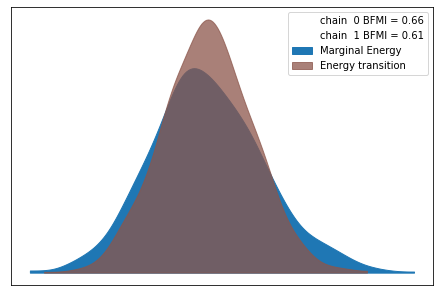

In [135]:
pm.energyplot(trace);

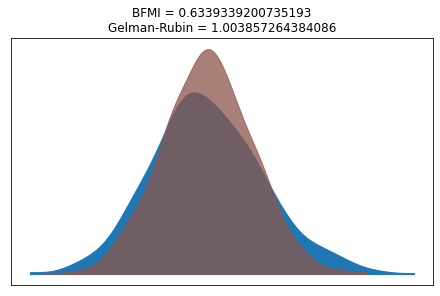

In [136]:
bfmi = pm.bfmi(trace)
max_gr = max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(trace).values())

(pm.energyplot(trace, legend=False, figsize=(6, 4)).set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));

## Post-stratification data

In [137]:
census_df = pd.read_stata('data/usa_00002.dta')

In [138]:
census_df.head()

,sample,serial,hhwt,cluster,stateicp,strata,pernum,perwt,sex,age,race,raced,educ,educd
0,2019 acs,1,11,2.019000e+12,alabama,220001,1,11,male,39,black/african american/negro,black/african american/negro,grade 10,grade 10
1,2019 acs,2,70,2.019000e+12,alabama,100001,1,70,female,21,white,white,grade 10,grade 10
2,2019 acs,3,20,2.019000e+12,alabama,110001,1,20,male,19,black/african american/negro,black/african american/negro,1 year of college,"1 or more years of college credit, no degree"
3,2019 acs,4,79,2.019000e+12,alabama,110001,1,79,male,77,white,white,grade 9,grade 9
4,2019 acs,5,53,2.019000e+12,alabama,270101,1,53,male,41,black/african american/negro,black/african american/negro,grade 9,grade 9


In [139]:
census_df.age[census_df.age=='less than 1 year old']='1'
census_df.age[census_df.age=='90 (90+ in 1980 and 1990)']='91'
census_df[['age']] = census_df[['age']].apply(pd.to_numeric)

census_df.loc[(census_df['age'] <= 29),  'age_cat'] = 'age_18-29'
census_df.loc[(census_df['age'] <= 44) & (census_df['age'] > 29),  'age_cat'] = 'age_30-44'
census_df.loc[(census_df['age'] <= 59) & (census_df['age'] > 44),  'age_cat'] = 'age_45-59'
census_df.loc[(census_df['age'] >= 60),  'age_cat'] = 'age_60_or_more'

census_df.loc[(census_df['educ'] == 'grade 12'), 'edu_cat'] = 'High school or less'
census_df.loc[(census_df['educ'] == '4 years of college'), 'edu_cat'] = 'Post secondary or higher'
census_df.loc[(census_df['educ'] == '1 year of college'), 'edu_cat'] = 'Some post secondary'
census_df.loc[(census_df['educ'] == '5+ years of college'), 'edu_cat'] = 'Graduate degree'
census_df.loc[(census_df['educ'] == 'nursery school to grade 4'), 'edu_cat'] = 'High school or less'
census_df.loc[(census_df['educ'] == '2 years of college'), 'edu_cat'] = 'Some post secondary'
census_df.loc[(census_df['educ'] == 'grade 5, 6, 7, or 8'), 'edu_cat'] = 'High school or less'
census_df.loc[(census_df['educ'] == 'n/a or no schooling'), 'edu_cat'] = 'High school or less'
census_df.loc[(census_df['educ'] == 'grade 11'), 'edu_cat'] = 'High school or less'
census_df.loc[(census_df['educ'] == 'grade 10'), 'edu_cat'] = 'High school or less'
census_df.loc[(census_df['educ'] == 'grade 9'), 'edu_cat'] = 'High school or less'

In [142]:
census_df.edu_cat.value_counts()

High school or less         1815689
Some post secondary          595884
Post secondary or higher     507242
Graduate degree              320738
Name: edu_cat, dtype: int64

In [143]:
us_state_abbrev = {'california': 'CA', 'texas': 'TX', 'florida': 'FL', 'new york': 'NY', 'pennsylvania': 'PA', 'illinois': 'IL', 
                   'ohio': 'OH', 'north carolina': 'NC', 'georgia': 'GA', 'michigan': 'MI', 'new jersey': 'NJ', 'virginia': 'VA', 
                   'washington': 'WA', 'arizona': 'AZ', 'massachusetts': 'MA', 'tennessee': 'TN', 'indiana': 'IN', 'missouri': 'MO',
                   'maryland': 'MD', 'wisconsin': 'WI', 'colorado': 'CO', 'minnesota': 'MN', 'south carolina': 'SC', 'alabama': 'AL', 
                   'kentucky': 'KY', 'louisiana': 'LA', 'oregon': 'OR', 'oklahoma': 'OK', 'connecticut': 'CT', 'iowa': 'IA',
                   'utah': 'UT', 'arkansas': 'AR', 'kansas': 'KS', 'nevada': 'NV', 'mississippi': 'MS', 'nebraska': 'NE', 
                   'new mexico': 'NM', 'west virginia': 'WV', 'idaho': 'ID', 'hawaii': 'HI', 'new hampshire': 'NH', 'maine': 'ME', 
                   'montana': 'MT', 'rhode island': 'RI', 'delaware': 'DE', 'south dakota': 'SD', 'north dakota': 'ND', 'alaska': 'AK', 
                   'district of columbia': 'DC', 'vermont': 'VT', 'wyoming': 'WY'}

census_df['state'] = census_df['stateicp'].map(us_state_abbrev)

In [145]:
map_dict = {'white': 'White', 'black/african american/negro': 'Black', 'other asian or pacific islander': 'Asian', 
            'other race, nec': 'Others', 'two major races': 'Others', 'chinese': 'Asian', 'american indian or alaska native': 'Others', 
            'three or more major races': 'Others', 'japanese': 'Asian'}
census_df['race_cat'] = census_df['race'].map(map_dict)

In [147]:
census_df = census_df[['sex', 'race_cat', 'age_cat', 'edu_cat', 'state']]
census_df = census_df.groupby(['state', 'sex', 'race_cat', 'age_cat', 'edu_cat']).size().reset_index().rename(columns={0: 'freq'})
census_df['percentage'] = 100 * census_df['freq']  / census_df['freq'].sum()

In [148]:
census_df.head()

,state,sex,race_cat,age_cat,edu_cat,freq,percentage
0,CT,male,Asian,age_18-29,Graduate degree,32,0.000988
1,CT,male,Asian,age_18-29,High school or less,206,0.006359
2,CT,male,Asian,age_18-29,Post secondary or higher,41,0.001266
3,CT,male,Asian,age_18-29,Some post secondary,33,0.001019
4,CT,male,Asian,age_30-44,Graduate degree,96,0.002963


In [150]:
ps_df = pd.merge(census_df, state_df[['state', 'region_num']], on='state')

In [151]:
ps_df.head()

,state,sex,race_cat,age_cat,edu_cat,freq,percentage,region_num
0,CT,male,Asian,age_18-29,Graduate degree,32,0.000988,1
1,CT,male,Asian,age_18-29,High school or less,206,0.006359,1
2,CT,male,Asian,age_18-29,Post secondary or higher,41,0.001266,1
3,CT,male,Asian,age_18-29,Some post secondary,33,0.001019,1
4,CT,male,Asian,age_30-44,Graduate degree,96,0.002963,1


In [152]:
ps_df['gender_num'] = le.fit_transform(ps_df['sex'])
ps_df['race_num'] = le.fit_transform(ps_df['race_cat'])
ps_df['edu_num'] = le.fit_transform(ps_df['edu_cat'])
ps_df['age_num'] = le.fit_transform(ps_df['age_cat'])
ps_df['state_num'] = le.fit_transform(ps_df['state'])

In [153]:
ps_gender_race = encode_gender_race(ps_df.gender_num, ps_df.race_num)
ps_age = ps_df.age_num.values
ps_edu = ps_df.edu_num.values
ps_age_edu = encode_age_edu(ps_df.age_num, ps_df.edu_num)
ps_region = ps_df.region_num.values
ps_state = ps_df.state_num.values
ps_n = ps_df.freq.values.astype(np.int64)

In [154]:
gender_race_.set_value(ps_gender_race)
age_.set_value(ps_age)
edu_.set_value(ps_edu)
age_edu_.set_value(ps_age_edu)
state_.set_value(ps_state)
use_poll_.set_value(0)
n_.set_value(ps_n)

In [155]:
with model:
    pp_trace = pm.sample_ppc(trace)

/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning:

sample_ppc() is deprecated.  Please use sample_posterior_predictive()

100%|██████████| 2000/2000 [00:10<00:00, 187.95it/s]


In [157]:
PP_COLS = ['pp_vote_2020_{}'.format(i) for i in range(pp_trace['obs'].shape[0])]
pp_df = pd.merge(ps_df, pd.DataFrame(pp_trace['obs'].T, columns=PP_COLS), left_index=True, right_index=True)

In [159]:
ps_prob = pp_df.groupby('state').apply(lambda df: df[PP_COLS].sum(axis=0) / df.freq.sum())

In [161]:
ps_mean = ps_prob.mean(axis=1)
ps_mean = ps_mean.reset_index().rename(columns = {0: 'mean'})
ps_mean['mean %'] = ps_mean['mean'] * 100

In [162]:
ps_mean.head()

,state,mean,mean %
0,AK,0.374558,37.455771
1,AL,0.400471,40.047112
2,AR,0.442948,44.294767
3,AZ,0.410059,41.005896
4,CA,0.301691,30.169066


In [177]:
fig = go.Figure(data=go.Choropleth(
    locations=ps_mean['state'],
    z=ps_mean['mean %'].astype(float),
    locationmode='USA-states',
    colorscale='Reds',
    autocolorscale=False,
    marker_line_color='white', # line markers between states
    colorbar_title="Mean %"
))

fig.update_layout(
    title_text='MRP estimate support for Trump by state in 2020 election poll<br>(Hover for breakdown)',
    geo = dict(
        scope='usa',
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(255, 255, 255)'),
)

fig.show()

In [169]:
fig = go.Figure(data=go.Scatter(x=vote_dt_df['% of vote'],
                                y=ps_mean['mean %'],
                                mode='markers',
                                text=ps_mean['state'])) # hover text goes here

fig.update_layout(title='Estimated vote for Trump in the poll', xaxis_title="Disaggregation estimate", yaxis_title="MRP estimate")
fig.show();

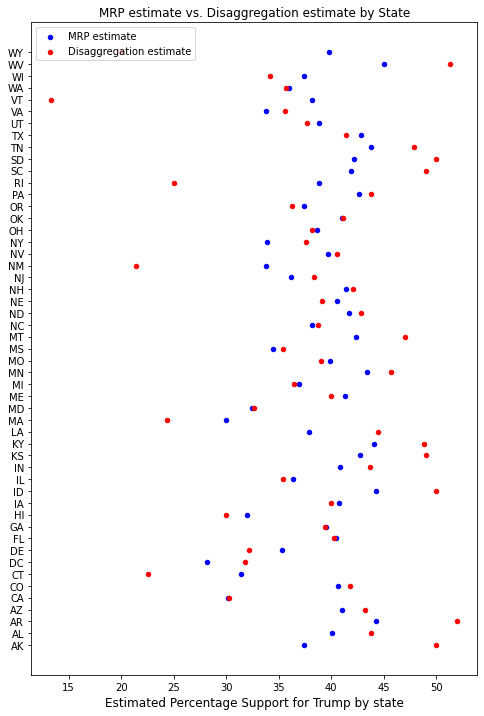

In [178]:
fig = plt.figure(figsize=(8, 12))

plt.scatter(ps_mean['mean %'], ps_mean['state'], s=20, c='b', marker="o", label='MRP estimate')
plt.scatter(vote_dt_df['% of vote'],vote_dt_df['state'], s=20, c='r', marker="o", label='Disaggregation estimate')
plt.legend(loc='upper left')
plt.title('MRP estimate vs. Disaggregation estimate by State')
plt.xlabel('Estimated Percentage Support for Trump by state', fontsize=12)
plt.show();

In [179]:
black_men_disagg_p = dt_df.loc[(dt_df['gender'] == 'Male') & (dt_df['race'] == 'Black')].groupby('state')['vote_2020'].mean().reset_index()
black_men_disagg_p['% of vote'] = black_men_disagg_p['vote_2020'] * 100

fig = go.Figure(data=go.Choropleth(
    locations=black_men_disagg_p['state'],
    z=black_men_disagg_p['% of vote'].astype(float),
    locationmode='USA-states',
    colorscale='Reds',
    autocolorscale=False,
#    text=support_df['text'], # hover text
    marker_line_color='white', # line markers between states
    colorbar_title="% of vote"
))

fig.update_layout(
    title_text='Disaggregation Estimate support for Trump among black men by state in 2020 election poll<br>(Hover for breakdown)',
    geo = dict(
        scope='usa',
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(255, 255, 255)'),
)

fig.show()

In [180]:
black_men_ps_mean = pp_df.loc[(pp_df['race_cat'] == 'Black') & (pp_df['sex'] == 'male')].groupby('state').apply(lambda df: (df[PP_COLS].sum(axis=0) / df.freq.sum())).mean(axis=1).reset_index().rename(columns={0: 'mean'})
black_men_ps_mean['% mean'] = black_men_ps_mean['mean'] * 100

fig = go.Figure(data=go.Choropleth(
    locations=black_men_ps_mean['state'],
    z=black_men_ps_mean['% mean'].astype(float),
    locationmode='USA-states',
    colorscale='Reds',
    autocolorscale=False,
#    text=support_df['text'], # hover text
    marker_line_color='white', # line markers between states
    colorbar_title="mean %"
))

fig.update_layout(
    title_text='MRP Estimate support for Trump among black men by state in 2020 election poll<br>(Hover for breakdown)',
    geo = dict(
        scope='usa',
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(255, 255, 255)'),
)

fig.show()